In [7]:
import numpy as np
import pandas as pd
import requests
import re

from collections import Counter
from wordcloud import WordCloud

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options

from bs4 import BeautifulSoup
import time
from langdetect import detect, LangDetectException
import spacy
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
# Cargar los dos CSV
df1 = pd.read_csv("./data/reviews_finales.csv") 
df2 = pd.read_csv("./data/reviews_finales_2.csv")
df3 = pd.read_csv("./data/reviews_finales_3.csv")

# Concatenar y resetear índice para evitar duplicados o índices desordenados
df = pd.concat([df1, df2, df3], ignore_index=True)

# Verifica el resultado
print(df.shape)

(8583, 6)


In [9]:
df.head()

,Unnamed: 0,movie_url,username,date,score,review
0,0,https://www.metacritic.com/movie/moonlight-201...,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
1,1,https://www.metacritic.com/movie/moonlight-201...,isabellacosta8,"Oct 10, 2024",10,[SPOILER ALERT: This review contains spoilers.]
2,2,https://www.metacritic.com/movie/moonlight-201...,Gabrielx593,"Oct 9, 2024",10,[SPOILER ALERT: This review contains spoilers.]
3,3,https://www.metacritic.com/movie/moonlight-201...,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
4,4,https://www.metacritic.com/movie/moonlight-201...,Alexmarshall,"Oct 16, 2023",10,Reallyamazing


In [10]:
df.shape

(8583, 6)

In [11]:
# Devuelve un booleano para cada fila indicando si es duplicada (excepto la primera aparición)
duplicated_rows = df.duplicated()

# Mostrar filas duplicadas
print(df[duplicated_rows])

Empty DataFrame
Columns: [Unnamed: 0, movie_url, username, date, score, review]
Index: []


In [12]:
# Aplicar la extracción y transformación del nombre de la película a la columna "movie_url"
df['movie_url'] = df['movie_url'].apply(lambda x: re.search(r'/movie/([^/]+)', x).group(1).replace('-', ' ').title())

# Renombrar la columna "movie_url" a "movie"
df = df.rename(columns={"movie_url": "movie"})

df.head(5)

,Unnamed: 0,movie,username,date,score,review
0,0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
1,1,Moonlight 2016,isabellacosta8,"Oct 10, 2024",10,[SPOILER ALERT: This review contains spoilers.]
2,2,Moonlight 2016,Gabrielx593,"Oct 9, 2024",10,[SPOILER ALERT: This review contains spoilers.]
3,3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
4,4,Moonlight 2016,Alexmarshall,"Oct 16, 2023",10,Reallyamazing


In [13]:
df = df[~df['review'].isna()] 

In [14]:
# Función para manejar excepciones y textos vacíos
def safe_detect(text):
    try:
        if text.strip():  # Asegurarse de que el texto no esté vacío
            return detect(text)
        else:
            return None  # Si el texto está vacío, devuelve None
    except LangDetectException:
        return None  # Si no puede detectar el idioma, devuelve None

# Eliminar las filas donde la columna 'review' contiene "SPOILER ALERT" y crear la columna 'sentiment' basada en la columna 'score'
df = (df[~df['review'].str.contains("SPOILER ALERT", case=True, na=False)]
              .assign(language = df['review'].apply(safe_detect)))

# Filtrar el DataFrame para quedarse solo con las filas donde el idioma es 'en'
df = df[df['language'] == 'en']

df = df.drop('language', axis = 1)

df.head(5)

,Unnamed: 0,movie,username,date,score,review
0,0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
3,3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
5,5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser..."
6,6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,"A refined production, with no obvious weakness..."
7,7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is..."


In [15]:
df['sentiment'] = df['score'].apply(lambda x: 'NEG' if x <= 3 else ('NEU' if 4 <= x <= 6 else 'POS'))

df.head(5)

,Unnamed: 0,movie,username,date,score,review,sentiment
0,0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...,POS
3,3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...,POS
5,5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser...",POS
6,6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,"A refined production, with no obvious weakness...",POS
7,7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is...",POS


In [16]:
df.shape

(7466, 7)

Instalación del modelo de spaCy

Para instalar el modelo `en_core_web_md` de **spaCy**, ejecuta el siguiente comando en tu **Anaconda Prompt** o **Terminal**:

```bash
python -m spacy download en_core_web_md


In [17]:
nlp = spacy.load('en_core_web_md')

In [18]:
from spacy.lang.en.stop_words import STOP_WORDS
print(STOP_WORDS)

{'thereafter', 'rather', 'something', 'my', 'myself', 'once', 'where', 'with', 'next', 'third', 'sixty', "'d", 'as', 'four', 'they', 'perhaps', 'anywhere', 'there', 'without', 'further', 'during', 'often', 'nine', 'against', 'being', 'themselves', 'take', 'down', 'among', 'whom', 'whose', 'hers', 'itself', 'at', 'so', 'empty', 'therein', 'nowhere', '‘ve', 'she', 'upon', 'several', 'such', 'over', 'since', 'anything', '’re', 'thereby', 'show', 'neither', 'becomes', 'then', 'should', 'whatever', 'under', 'you', 'already', '‘s', 'been', 'before', 'these', 'everywhere', 'sometimes', 'seeming', 'him', 'throughout', 'thereupon', 'three', 'call', 'across', 'still', 'herein', 'becoming', 'yours', 'former', 'most', 'made', 'along', 'by', 'too', 'above', '’ll', 'least', 'quite', 'serious', 'few', 'not', 'many', 'it', 'namely', 'one', 'seem', 'all', 'mostly', 'though', 'would', 'front', 'any', 'eleven', 'forty', 'have', 'must', 'name', 'the', 'toward', 'in', 'doing', 'same', 'fifty', 'because', '

Podemos calcular un porcentaje de stopwords para cada clase, para ver directamente la influencia de ellos en el texto. 

In [19]:
# función para calcular el porcentaje de stopwords en un texto
def stopword_percentage(tokens):
    stopword_count = sum(1 for word in tokens if word in STOP_WORDS)
    stopword_pct = (stopword_count / len(tokens)) * 100
    return stopword_pct

# Función para limpiar, tokenizar y lematizar
def process_text_column2(df, text_column):

    df['stopword_percentage'] = df[text_column].apply(stopword_percentage)
    return df

def graphics_stopwords(df, text_column):

    stopwords_by_rating = df.groupby(text_column)['stopword_percentage'].mean()
    meaningful_by_rating = 100 - stopwords_by_rating

    plt.figure(figsize=(8, 6))
    bar1 = plt.bar(stopwords_by_rating.index, stopwords_by_rating, color='#2C77A8', label='Stopwords')
    bar2 = plt.bar(meaningful_by_rating.index, meaningful_by_rating, bottom=stopwords_by_rating, color='#87CEEB', label='Palabras con significado')

    plt.xlabel(text_column)
    plt.ylabel('Porcentaje')
    plt.title('Porcentaje de stopwords vs. con significado')
    plt.xticks(stopwords_by_rating.index)
    plt.legend()
    plt.show()

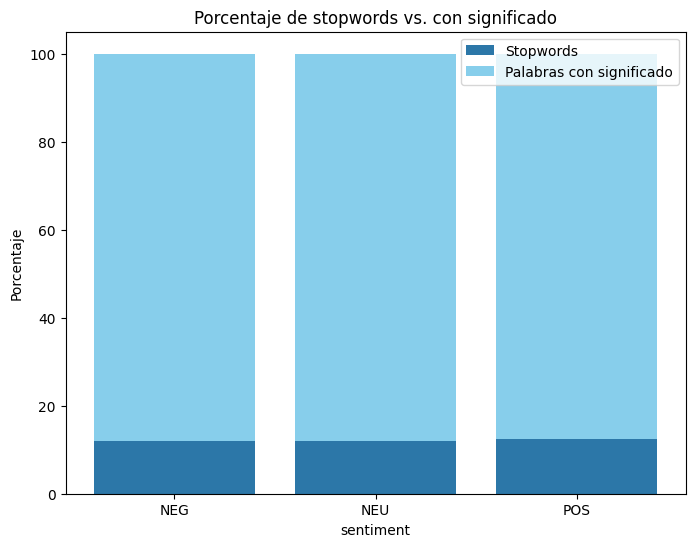

In [20]:
process_text_column2(df, 'review')
graphics_stopwords(df, 'sentiment')

Podemos ver como el porcentaje de stopwords es de alrededor del 15%

In [21]:
# Definir el patrón para los caracteres especiales
pat = '[{}]'.format(re.escape(string.punctuation))

# Definir la función para normalizar, lematizar y eliminar puntuación
def normalize_document_remove_punct(doc):

    doc = re.sub(r'\d+', '', doc)
    # Separamos en tokens
    tokens = nlp(doc)
    
    # Quitamos puntuación, espacios y stopwords, y aplicamos lematización
    filtered_tokens = [re.sub(pat, ' ', t.lemma_.lower())  # Usamos t.lemma_ para lematizar
                       for t in tokens
                       if not t.is_stop        # Eliminar stopwords
                       and not t.is_punct      # Eliminar puntuación
                       and not t.is_space]      # Eliminar espacios]     
    
    # Juntamos de nuevo en una cadena
    doc = ' '.join(filtered_tokens)
    
    return doc

# Aplicar la función a cada elemento de la columna 'contenido' tanto en treino como en test
df['review'] = df['review'].apply(normalize_document_remove_punct)

df.head(5)

,Unnamed: 0,movie,username,date,score,review,sentiment,stopword_percentage
0,0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,absolutely brilliant film character deep plot ...,POS,16.875000
3,3,Moonlight 2016,NWR1,"Mar 31, 2024",9,feel emotion long time chiron manifest emotion...,POS,12.867647
5,5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,movie masterpiece deserve oscar,POS,10.294118
6,6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,refined production obvious weakness base ratio...,POS,13.333333
7,7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,decent movie story so scoring great visual d...,POS,13.131313


In [ ]:
# import pandas as pd

# # Suponiendo que df ya está cargado y tiene la columna "sentiment"
# df_pos = df[df['sentiment'] == 'POS']
# df_neu = df[df['sentiment'] == 'NEU']
# df_neg = df[df['sentiment'] == 'NEG']

# # Obtener el tamaño mínimo entre las clases
# min_size = min(len(df_neu), len(df_neg))

# # Reducir POS aleatoriamente al tamaño mínimo
# df_pos_bal = df_pos.sample(n=min_size, random_state=42)

# # Combinar los tres subconjuntos balanceados
# df_balanced = pd.concat([df_pos_bal, df_neu, df_neg], ignore_index=True)

# # Opcional: mezclar el resultado final
# df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# # Mostrar resumen
# print(df['sentiment'].value_counts())


sentiment
NEU    1770
NEG    1735
POS    1735
Name: count, dtype: int64


## BERT

In [35]:
# Separar para clasificación de sentimiento
X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42)

# Separar para predicción del score
X_train_score, X_test_score, y_train_score, y_test_score = train_test_split(
    df['review'], df['score'].astype(int), test_size=0.2, random_state=42)

In [36]:
from sentence_transformers import SentenceTransformer

# Modelo multilingüe pequeño y rápido
model = SentenceTransformer('all-mpnet-base-v2')


# Aplicar BERT a tus textos de test
X_train_bert = model.encode(X_train_sent.tolist(), convert_to_numpy=True)
X_test_bert = model.encode(X_test_sent.tolist(), convert_to_numpy=True)

In [37]:
le = LabelEncoder()
y_train_sent_enc = le.fit_transform(y_train_sent)
y_test_sent_enc = le.transform(y_test_sent)

modelLR = LogisticRegression(solver='liblinear')
#Entrenamos el modelo con el conjunto de train
modelLR.fit(X_train_bert, y_train_sent_enc)
prediccion = modelLR.predict(X_test_bert)


print(classification_report(y_test_sent_enc, prediccion, target_names=le.classes_))

              precision    recall  f1-score   support

         NEG       0.69      0.70      0.69       359
         NEU       0.56      0.48      0.52       349
         POS       0.68      0.76      0.71       340

    accuracy                           0.65      1048
   macro avg       0.64      0.65      0.64      1048
weighted avg       0.64      0.65      0.64      1048



In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(class_weight='balanced', solver='liblinear')
clf.fit(X_train_bert, y_train_sent_enc)
y_pred = clf.predict(X_test_bert)

print(classification_report(y_test_sent_enc, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

         NEG       0.69      0.71      0.70       359
         NEU       0.57      0.48      0.52       349
         POS       0.68      0.76      0.72       340

    accuracy                           0.65      1048
   macro avg       0.64      0.65      0.64      1048
weighted avg       0.64      0.65      0.64      1048

